#Cпособы реализовать линейную регрессию

### Пример с использованием библиотеки sklearn

Посмотрим, как будет работать классическая реализаци линейной регрессии с использованием библиотеки `sklearn`. Для начала построим модель:

In [ ]:
import pandas as pd
import torch
from torch.utils.data import TensorDataset, DataLoader
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = []
with open('/content/drive/MyDrive/DeepLearning/housing.csv') as f:
  for line in f:
    data.append(list(map(float, line.split())))

В данных 14 столбцов, последний - y.
1. CRIM
2. ZN
3. INDUS
4. CHAS
5. NOX
6. RM
7. AGE
8. DIS
9. RAD
10. TAX
11. PTRATIO
12. B
13. LSTAT
14. MEDV

In [ ]:
df = pd.DataFrame.from_records(data, columns=["CRIM", "ZN", "INDUS", "CHAS",
                                              "NOX", "RM", "AGE", "DIS", "RAD",
                                              "TAX", "PTRATIO", "B", "LSTAT",
                                              "MEDV"])

In [ ]:
df.head(3)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7


Оценим признаки на информативность.

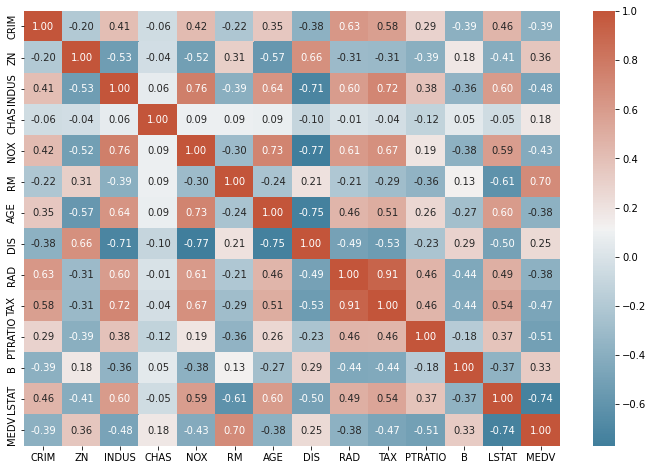

In [ ]:
plt.figure(figsize=(12, 8))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(df.corr(),annot=True,fmt='.2f',cmap=cmap) 
plt.show()

По корреляционной матрице излишними кажутся признаки RAD, NOX, INDUS. Посмотрим подробнее.

In [ ]:
df_min = df[["CRIM", "ZN", "CHAS",
             "RM", "AGE", "DIS",
             "TAX", "PTRATIO", "B", "LSTAT", "MEDV"]]
df_min.head(3)

,CRIM,ZN,CHAS,RM,AGE,DIS,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,0.0,6.575,65.2,4.0900,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,0.0,6.421,78.9,4.9671,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,0.0,7.185,61.1,4.9671,242.0,17.8,392.83,4.03,34.7


In [ ]:
df_tensor = torch.nn.functional.normalize(torch.tensor(df.values.tolist()))
df_conv = pd.DataFrame(df_tensor.numpy(), columns=["CRIM", "ZN", "INDUS", "CHAS",
                                              "NOX", "RM", "AGE", "DIS", "RAD",
                                              "TAX", "PTRATIO", "B", "LSTAT", "MEDV"])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


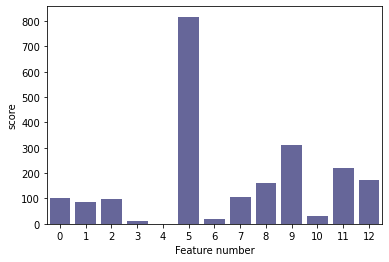

In [ ]:
def select_features(X_train, y_train, X_test, func):
	fs = SelectKBest(score_func=func, k='all')
	fs.fit(X_train, y_train)
	X_train_fs = fs.transform(X_train)
	X_test_fs = fs.transform(X_test)
	return X_train_fs, X_test_fs, fs
 
X_train, X_test, y_train, y_test = train_test_split(df_conv.iloc[:, :-1], df_conv.iloc[:, -1], test_size=0.3, random_state=1)
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test, f_regression)
sns.barplot([i for i in range(len(fs.scores_))], fs.scores_, color="blue", saturation=.2)
plt.xlabel("Feature number")
plt.ylabel("score")
plt.show()

Признаки 3, 4, 5 и 10 наименее информативны. Это столбцы CHAS, NOX, AGE, PTRATIO.

Посмотрим, как будет работать модель без признака NOX, т.к. среди всех он коррелирует с наибольшим количеством признаков и имеет наименьший коэффициент значимости.

In [ ]:
#разделим датасет на обучающую и тестовую выборки
train_size = int(df.shape[0]*0.7)
train, test = torch.utils.data.random_split(df_tensor, [train_size, df.shape[0]-train_size])
X_train = torch.tensor(df[["CRIM", "ZN", "INDUS", "CHAS",
                                              "RM", "AGE", "DIS", "RAD",
                                              "TAX", "PTRATIO", "B", "LSTAT"]][df.index.isin(train.indices)].values.tolist())
y_train = torch.tensor(df["MEDV"][df.index.isin(train.indices)].tolist())
X_test = torch.tensor(df[["CRIM", "ZN", "INDUS", "CHAS",
                                              "RM", "AGE", "DIS", "RAD",
                                              "TAX", "PTRATIO", "B", "LSTAT"]][df.index.isin(test.indices)].values.tolist())
y_test = torch.tensor(df["MEDV"][df.index.isin(test.indices)].tolist())

In [ ]:
from sklearn.linear_model import SGDRegressor

max_iter = 100
eta0 = 0.0001
model = SGDRegressor(
    loss='squared_loss',
    learning_rate='constant',
    max_iter=max_iter,
    eta0=eta0
)

Чтобы нормализовать значения для обучения и валидации модели можно воспользоваться `StandardScaler` из библиотеки `sklearn`:

In [ ]:
from sklearn.preprocessing import StandardScaler
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.33, random_state = 18)
x_scaler = StandardScaler()
y_scaler = StandardScaler()
X_train = x_scaler.fit_transform(X_train)
Y_train = y_scaler.fit_transform(Y_train.values.reshape(-1, 1))
X_test = x_scaler.transform(X_test)
Y_test = y_scaler.transform(Y_test.values.reshape(-1, 1))

In [ ]:
model.fit(X_train, Y_train.ravel())

SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.0001, fit_intercept=True, l1_ratio=0.15,
             learning_rate='constant', loss='squared_loss', max_iter=100,
             n_iter_no_change=5, penalty='l2', power_t=0.25, random_state=None,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)

In [ ]:
Y_pred = model.predict(X_test)

Чтобы найти среднеквадратичную ошибку и коэффициент детерминации:

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

r2_score(Y_test, Y_pred), mean_squared_error(Y_test, Y_pred)

(0.4962872430862003, 0.48766343920140615)

In [ ]:
model.coef_, model.intercept_

(array([0.55192255]), array([-4.65889455e-05]))

In [ ]:
mean_squared_error(Y_test, Y_pred), r2_score(Y_test, Y_pred)

(0.48766343920140615, 0.4962872430862003)

Реализуем обучение линейной регрессии для задачи boston house prices с использованием torch’а.

In [ ]:
len(y_test)

152

In [ ]:
batch = 50
dataset = TensorDataset(X_train, y_train)
data_iter = DataLoader(dataset, batch, shuffle=True)

In [ ]:
model = torch.nn.Sequential(torch.nn.Flatten(),
                            torch.nn.Linear(12, batch), 
                            torch.nn.ReLU(), 
                            torch.nn.Linear(batch, 1))
loss = torch.nn.MSELoss(reduction="mean")
#trainer = torch.optim.SGD(model.parameters(), lr=0.0000001)
trainer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
loss_points = []
num_epochs = 3001
for epoch in range(num_epochs):
  for X, y in data_iter:
    trainer.zero_grad()
    l = loss(model(X).reshape(-1), y)
    l.backward()
    trainer.step()
  
  train_l = loss(model.forward(X_train).reshape(-1), y_train).item()
  loss_points.append((epoch, train_l))
  if epoch % 500 == 0 or epoch == num_epochs-1:
    print("epoch: {:5} | loss: {:5}".format(epoch, train_l))
    #print("w:", model[0].weight.data, "b:", model[0].bias.data)

epoch:     0 | loss: 345.62701416015625
epoch:   500 | loss: 20.698915481567383
epoch:  1000 | loss: 17.84395408630371
epoch:  1500 | loss: 12.331870079040527
epoch:  2000 | loss: 11.67218017578125
epoch:  2500 | loss: 9.879100799560547
epoch:  3000 | loss: 8.299783706665039


In [ ]:
train_loss = loss(model.forward(X_train).reshape(-1), y_train).item()
test_loss = loss(model.forward(X_test).reshape(-1), y_test).item()
train_loss, test_loss

(8.299783706665039, 10.508563041687012)

In [ ]:
loss_df = pd.DataFrame.from_records(loss_points, columns=["epoch", "loss"])

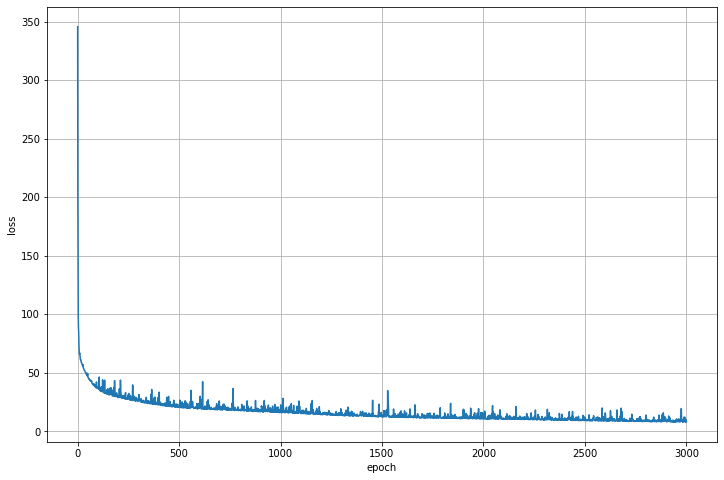

In [ ]:
plt.figure(figsize=(12, 8))
sns.lineplot(data=loss_df, x="epoch", y="loss")
plt.grid()
plt.show()

Оценим модель. Посчитаем коэффициент детерминации и MAE.

In [ ]:
print("Train R2:", r2_score(y_train.numpy(), model.forward(X_train).reshape(-1).detach().numpy()))
print("Test  R2:", r2_score(y_test.numpy(), model.forward(X_test).reshape(-1).detach().numpy()))

Train R2: 0.902174266572647
Test  R2: 0.8736270833283777


In [ ]:
print("Train MAE:", mean_absolute_error(y_train.numpy(), model.forward(X_train).reshape(-1).detach().numpy()))
print("Test  MAE:", mean_absolute_error(y_test.numpy(), model.forward(X_test).reshape(-1).detach().numpy()))

Train MAE: 2.015892
Test  MAE: 2.4411118
